In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
from scipy.sparse import csr_matrix
from tqdm.notebook import tqdm
from implicit.bpr import BayesianPersonalizedRanking
from implicit.evaluation import train_test_split, precision_at_k

In [2]:
data_dir = 'data/25m'

# we are working with movie data, but we'll name
# the movie as item to make it more generic to
# all use-cases
user_col = 'userId'
item_col = 'movieId'
value_col = 'rating'
time_col = 'timestamp'

rating_path = os.path.join(data_dir, 'ratings.csv')
df_raw = pd.read_csv(rating_path)
print('dimension: ', df_raw.shape)
df_raw.head()

dimension:  (25000095, 4)


,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [3]:
title_col = 'title'
genre_col = 'genres'

item_info_path = os.path.join(data_dir, 'movies.csv')
df_item = pd.read_csv(item_info_path)
df_item = df_item[df_item[genre_col] != '(no genres listed)']
print('dimension: ', df_item.shape)
df_item.head()

dimension:  (57361, 3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
class Item:
    """
    Data holder for our item.
    
    Parameters
    ----------
    id : int
  
    title : str

    genre : dict[str, float]
        The item/movie's genre distribution, where the key
        represents the genre and value corresponds to the
        ratio of that genre.

    score : float
        Score for the item, potentially generated by some
        recommendation algorithm.
    """
    def __init__(self, _id, title, genres, score=None):
        self.id = _id
        self.title = title
        self.score = score
        self.genres = genres

    def __repr__(self):
        return self.title


def create_item_mapping(df_item, item_col, title_col, genre_col):
    """Create a dictionary of item id to Item lookup."""
    item_mapping = {}
    for row in df_item.itertuples():
        item_id = getattr(row, item_col)
        item_title = getattr(row, title_col)
        item_genre = getattr(row, genre_col)

        splitted = item_genre.split('|')
        genre_ratio = 1. / len(splitted)
        item_genre = {genre: genre_ratio for genre in splitted}

        item = Item(item_id, item_title, item_genre)
        item_mapping[item_id] = item

    return item_mapping
    

item_mapping = create_item_mapping(df_item, item_col, title_col, genre_col)
item_mapping[1]

Toy Story (1995)

In [5]:
# convert to implicit feedback data and filter out
# movies that doesn't have any genre
df_rating = df_raw[df_raw[value_col] >= 4.0].copy()
df_rating = df_rating.merge(df_item, on=item_col)

for col in (user_col, item_col):
    df_rating[col] = df_rating[col].astype('category')

# the original id are converted to indices to create
# the sparse matrix, so we keep track of the mappings here
# e.g. a userId 1 will correspond to index 0 in our sparse matrix
index2user = df_rating[user_col].cat.categories
index2item = df_rating[item_col].cat.categories

print('dimension: ', df_rating.shape)
df_rating.head()

dimension:  (12442311, 6)


,userId,movieId,rating,timestamp,title,genres
0,1,296,5.0,1147880044,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
1,3,296,5.0,1439474476,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
2,4,296,4.0,1573938898,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
3,5,296,4.0,830786155,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
4,7,296,4.0,835444730,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller


In [6]:
def create_user_item_csr_matrix(data, user_col, item_col, value_col):
    rows = data[user_col].cat.codes
    cols = data[item_col].cat.codes
    values = data[value_col].astype(np.float32)
    return csr_matrix((values, (rows, cols)))


user_item = create_user_item_csr_matrix(df_rating, user_col, item_col, value_col)
user_item

<162342x38715 sparse matrix of type '<class 'numpy.float32'>'
	with 12442311 stored elements in Compressed Sparse Row format>

In [15]:
np.random.seed(1234)
user_item_train, user_item_test = train_test_split(user_item, train_percentage=0.8)
user_item_train

<162342x38715 sparse matrix of type '<class 'numpy.float32'>'
	with 9953124 stored elements in Compressed Sparse Row format>

In [16]:
user_item_test

<162342x38715 sparse matrix of type '<class 'numpy.float32'>'
	with 2489187 stored elements in Compressed Sparse Row format>

In [17]:
# the model expects item-user sparse matrix,
# i.e. the rows represents item and the column
# represents users
np.random.seed(1234)
bpr = BayesianPersonalizedRanking(iterations=70)
bpr.fit(user_item_train.T.tocsr())

In [18]:
precision = precision_at_k(bpr, user_item_train, user_item_test, K=10)
precision

0.1622381841382612

In [19]:
user_item_test

<162342x38715 sparse matrix of type '<class 'numpy.float32'>'
	with 2489187 stored elements in Compressed Sparse Row format>

In [20]:
# look a the first user
user_id = 1

# find the index that the user interacted with,
# we can then map this to a list of Item, note that we need to first
# map the recommended index to the actual itemId/movieId first
interacted_ids = user_item_train[user_id].nonzero()[1]
interacted_items = [item_mapping[index2item[index]] for index in interacted_ids]
interacted_items[:10]

[Apollo 13 (1995),
 Rob Roy (1995),
 French Kiss (1995),
 Star Wars: Episode IV - A New Hope (1977),
 Shawshank Redemption, The (1994),
 Tommy Boy (1995),
 Clear and Present Danger (1994),
 Forrest Gump (1994),
 Lion King, The (1994),
 Fugitive, The (1993)]

In [21]:
# it returns the recommended index and their corresponding score
topn = 50
reco = bpr.recommend(user_id, user_item_train, N=topn)
reco[:10]

[(4414, 3.749813),
 (5494, 3.603307),
 (2403, 3.5894835),
 (5137, 3.5491061),
 (6398, 3.4769351),
 (3927, 3.4084716),
 (7755, 3.397572),
 (3797, 3.3497553),
 (6596, 3.2890315),
 (4413, 3.2531328)]

In [22]:
# map the index to Item
reco_items = [item_mapping[index2item[index]] for index, _ in reco]
reco_items[:10]

[Man from Snowy River, The (1982),
 Jonah: A VeggieTales Movie (2002),
 October Sky (1999),
 Rookie, The (2002),
 Seabiscuit (2003),
 Gettysburg (1993),
 Memphis Belle (1990),
 Remember the Titans (2000),
 Luther (2003),
 Return to Snowy River (a.k.a. The Man From Snowy River II) (1988)]

In [23]:
def compute_genre_distr(items):
    """Compute the genre distribution for a given list of Items."""
    distr = {}
    for item in items:
        for genre, score in item.genres.items():
            genre_score = distr.get(genre, 0.)
            distr[genre] = genre_score + score

    # we normalize the summed up probability so it sums up to 1
    # and round it to three decimal places, adding more precision
    # doesn't add much value and clutters the output
    for item, genre_score in distr.items():
        normed_genre_score = round(genre_score / len(items), 3)
        distr[item] = normed_genre_score

    return distr

In [24]:
# we can check that the probability does in fact add up to 1
# np.array(list(interacted_distr.values())).sum()
interacted_distr = compute_genre_distr(interacted_items)
interacted_distr

{'Adventure': 0.147,
 'Drama': 0.226,
 'IMAX': 0.008,
 'Action': 0.103,
 'Romance': 0.073,
 'War': 0.026,
 'Comedy': 0.114,
 'Sci-Fi': 0.058,
 'Crime': 0.022,
 'Thriller': 0.075,
 'Animation': 0.021,
 'Children': 0.037,
 'Musical': 0.015,
 'Fantasy': 0.046,
 'Western': 0.005,
 'Horror': 0.008,
 'Mystery': 0.015}

In [40]:
user_id = 0
summ = 0
for user_id in range(2400):
    
# find the index that the user interacted with,
# we can then map this to a list of Item, note that we need to first
# map the recommended index to the actual itemId/movieId first
    interacted_ids = user_item_train[user_id].nonzero()[1]
    interacted_items = [item_mapping[index2item[index]] for index in interacted_ids]
    interacted_items[:10]
    interacted_distr = compute_genre_distr(interacted_items)
    import operator
    n = 0
    p = interacted_distr.copy()
    r = {x:0 for x in interacted_distr.keys()}
    while n < 50:
        m = max(p.items(), key=operator.itemgetter(1))[0]
        r[m] += 1
        n += 1
        p[m] = p[m] / (2*r[m]+1)
        
    for i, j in r.items():
        r[i] = j/50
        
    summ += compute_kl_divergence(interacted_distr, r)

In [41]:
summ / 2400

0.41939682758907293

In [29]:
reco_distr = compute_genre_distr(reco_items)
reco_distr

{'Drama': 0.414,
 'Romance': 0.073,
 'Western': 0.028,
 'Animation': 0.017,
 'Children': 0.043,
 'Musical': 0.007,
 'War': 0.063,
 'Action': 0.105,
 'Adventure': 0.075,
 'Comedy': 0.052,
 'Thriller': 0.014,
 'Sci-Fi': 0.02,
 'Documentary': 0.02,
 'Fantasy': 0.032,
 'Crime': 0.013,
 'IMAX': 0.01,
 'Mystery': 0.014}

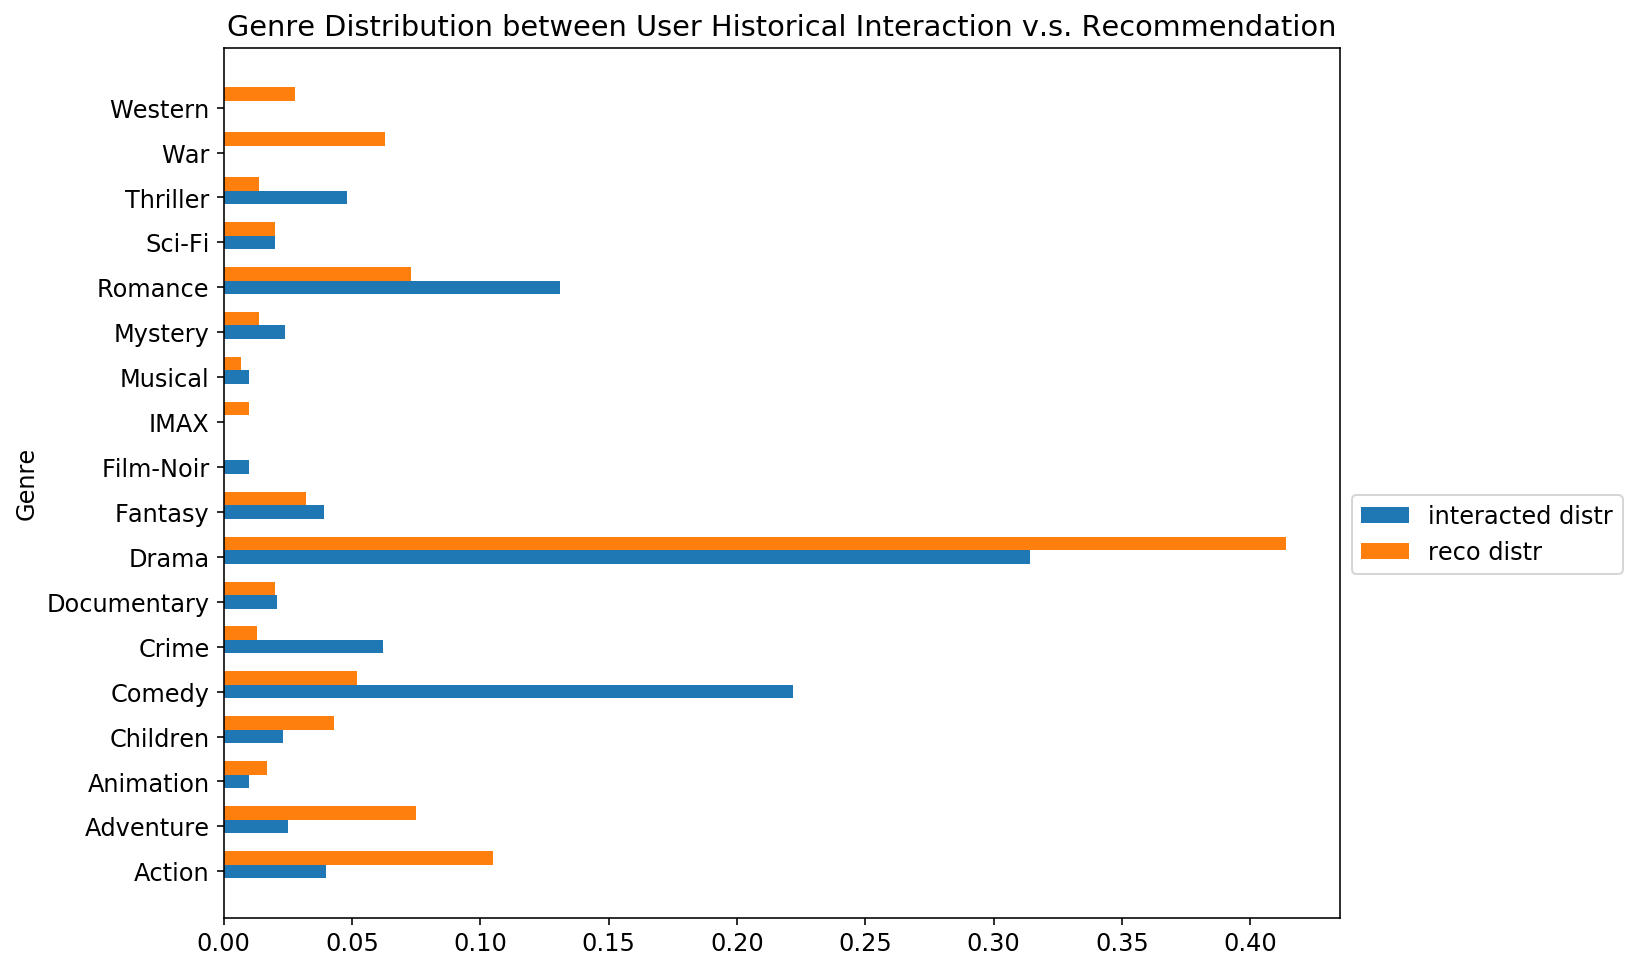

In [30]:
# change default style figure and font size
plt.rcParams['figure.figsize'] = 10, 8
plt.rcParams['font.size'] = 12


def distr_comparison_plot(interacted_distr, reco_distr, width=0.3):
    
    # the value will automatically be converted to a column with the
    # column name of '0'
    interacted = pd.DataFrame.from_dict(interacted_distr, orient='index')
    reco = pd.DataFrame.from_dict(reco_distr, orient='index')
    df = interacted.join(reco, how='outer', lsuffix='_interacted')

    n = df.shape[0]
    index = np.arange(n)
    plt.barh(index, df['0_interacted'], height=width, label='interacted distr')
    plt.barh(index + width, df['0'], height=width, label='reco distr')
    plt.yticks(index, df.index)
    plt.legend(bbox_to_anchor=(1, 0.5))
    plt.title('Genre Distribution between User Historical Interaction v.s. Recommendation')
    plt.ylabel('Genre')
    plt.show()
    
    
distr_comparison_plot(interacted_distr, reco_distr)

In [31]:
interacted_distr

{'Drama': 0.314,
 'Romance': 0.131,
 'Comedy': 0.222,
 'Adventure': 0.025,
 'Fantasy': 0.039,
 'Mystery': 0.024,
 'Sci-Fi': 0.02,
 'Thriller': 0.048,
 'Crime': 0.062,
 'Action': 0.04,
 'Documentary': 0.021,
 'Children': 0.023,
 'Animation': 0.01,
 'Musical': 0.01,
 'Film-Noir': 0.01}

In [32]:
def compute_kl_divergence(interacted_distr, reco_distr, alpha=0.02):
    """
    KL (p || q), the lower the better.

    alpha is not really a tuning parameter, it's just there to make the
    computation more numerically stable.
    """
    kl_div = 0.
    for genre, score in interacted_distr.items():
        reco_score = reco_distr.get(genre, 0.)
        reco_score = (1 - alpha) * reco_score + alpha * score
        if reco_score==0:
            kl_div += score
        else:
            kl_div += score * np.log2(score / reco_score)

    return kl_div


compute_kl_divergence(interacted_distr, reco_distr)

0.614195752019819

In [33]:
def generate_item_candidates(model, user_item, user_id, index2item, item_mapping,
                             filter_already_liked_items=True):
    """
    For a given user, generate the list of items that we can recommend, during this
    step, we will also attach the recommender's score to each item.
    """
    n_items = user_item.shape[1]
    
    # this is how implicit's matrix factorization generates
    # the scores for each item for a given user, modify this
    # part of the logic if we were to use a completely different
    # algorithm to generate the ranked items
    user_factor = model.user_factors[user_id]
    scores = model.item_factors.dot(user_factor)

    liked = set()
    if filter_already_liked_items:
        liked = set(user_item[user_id].indices)

    item_ids = set(np.arange(n_items))
    item_ids -= liked

    items = []
    for item_id in item_ids:
        item = item_mapping[index2item[item_id]]
        item.score = scores[item_id]
        items.append(item)

    return items

In [34]:
items = generate_item_candidates(bpr, user_item_train, user_id, index2item, item_mapping)
print('number of item candidates:', len(items))
items[:5]

number of item candidates: 38667


[Toy Story (1995),
 Jumanji (1995),
 Grumpier Old Men (1995),
 Waiting to Exhale (1995),
 Father of the Bride Part II (1995)]

In [35]:
def compute_utility(reco_items, interacted_distr, lmbda=0.5):
    """
    Our objective function for computing the utility score for
    the list of recommended items.

    lmbda : float, 0.0 ~ 1.0, default 0.5
        Lambda term controls the score and calibration tradeoff,
        the higher the lambda the higher the resulting recommendation
        will be calibrated. Lambda is keyword in Python, so it's
        lmbda instead ^^
    """
    reco_distr = compute_genre_distr(reco_items)
    kl_div = compute_kl_divergence(interacted_distr, reco_distr)

    total_score = 0.0
    for item in reco_items:
        total_score += item.score
    
    # kl divergence is the lower the better, while score is
    # the higher the better so remember to negate it in the calculation
    utility = (1 - lmbda) * total_score - lmbda * kl_div
    return utility

In [36]:
def calib_recommend(items, interacted_distr, topn, lmbda=0.5):
    """
    start with an empty recommendation list,
    loop over the topn cardinality, during each iteration
    update the list with the item that maximizes the utility function.
    """
    calib_reco = []
    for _ in range(topn):
        max_utility = -np.inf
        for item in items:
            if item in calib_reco:
                continue

            utility = compute_utility(calib_reco + [item], interacted_distr, lmbda)
            if utility > max_utility:
                max_utility = utility
                best_item = item

        calib_reco.append(best_item)
        
    return calib_reco

In [37]:
start = time.time()
calib_reco_items = calib_recommend(items, interacted_distr, topn, lmbda=0.99)
elapsed = time.time() - start
print('elapsed: ', elapsed)
calib_reco_items

elapsed:  92.72657990455627


[Once Upon a Time (2008),
 Princes and Princesses (2000),
 Mary's Land (2013),
 I Like It Like That (1994),
 Blue in the Face (1995),
 Kansas City (1996),
 Bitter Moon (1992),
 Love & Human Remains (1993),
 Crow, The (1994),
 1-900 (06) (1994),
 Flower of My Secret, The (La flor de mi secreto) (1995),
 Even Cowgirls Get the Blues (1993),
 Super Mario Bros. (1993),
 Nadja (1994),
 Amateur (1994),
 In the Bleak Midwinter (1995),
 Sexual Life of the Belgians, The (Vie sexuelle des Belges 1950-1978, La) (1994),
 Clockers (1995),
 Crooklyn (1994),
 Awfully Big Adventure, An (1995),
 French Twist (Gazon maudit) (1995),
 Last Action Hero (1993),
 Double Happiness (1994),
 Nina Takes a Lover (1994),
 Strange Days (1995),
 Denise Calls Up (1995),
 James and the Giant Peach (1996),
 Funeral, The (1996),
 Death and the Maiden (1994),
 Heidi Fleiss: Hollywood Madam (1995),
 Love and Other Catastrophes (1996),
 Jeffrey (1995),
 I Shot Andy Warhol (1996),
 Bullets Over Broadway (1994),
 Thieves (Vol


original reco kl-divergence score: 0.614195752019819
calibrated reco kl-divergence score: 0.006368205893693317


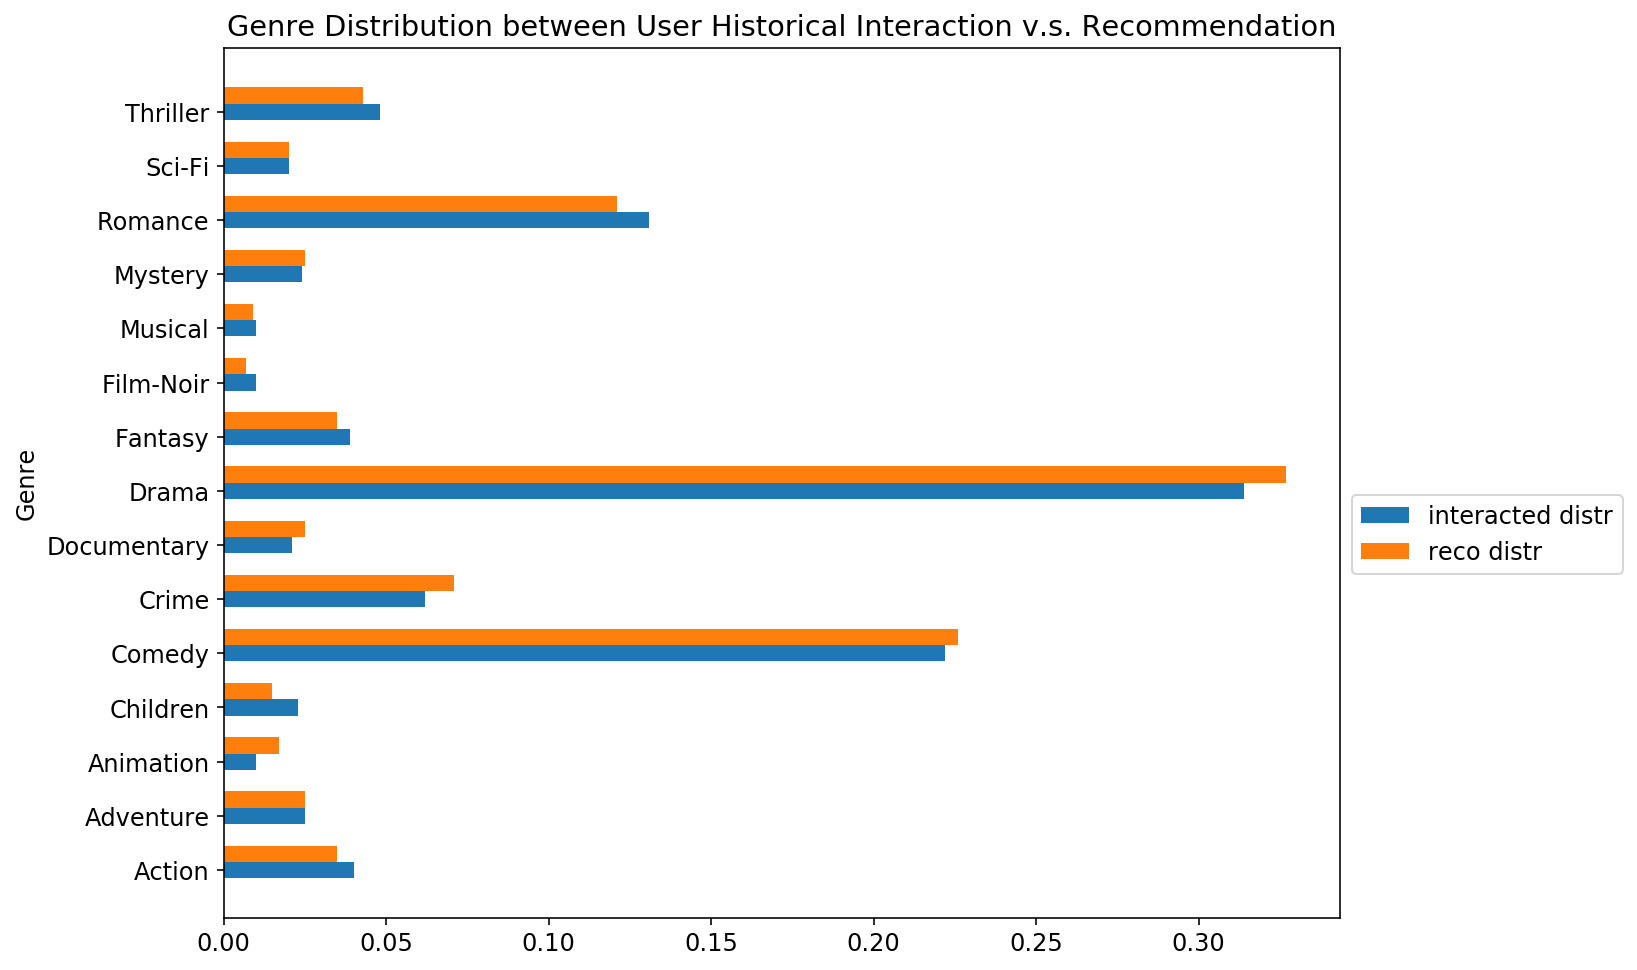

In [38]:
calib_reco_distr = compute_genre_distr(calib_reco_items)
calib_reco_kl_div = compute_kl_divergence(interacted_distr, calib_reco_distr)
reco_kl_div = compute_kl_divergence(interacted_distr, reco_distr)
print('\noriginal reco kl-divergence score:', reco_kl_div)
print('calibrated reco kl-divergence score:', calib_reco_kl_div)

distr_comparison_plot(interacted_distr, calib_reco_distr)

In [39]:
def precision(user_item, user_id, reco_items, index2item):
    indptr = user_item.indptr
    indices = user_item.indices

    reco_ids = {item.id for item in reco_items}
    likes = {index2item[indices[i]] for i in range(indptr[user_id], indptr[user_id + 1])}

    relevant = len(reco_ids & likes)
    total = min(len(reco_items), len(likes))
    return relevant / total

In [42]:
reco_precision = precision(user_item_test, user_id, reco_items, index2item)
calib_reco_precision = precision(user_item_test, user_id, calib_reco_items, index2item)
print('original reco precision score:', reco_precision)
print('calibrated reco precision score:', calib_reco_precision)

original reco precision score: 0.0
calibrated reco precision score: 0.0


In [44]:
start = time.time()
calib_reco_items = calib_recommend(items, interacted_distr, topn, lmbda=0.5)
elapsed = time.time() - start
print('elapsed: ', elapsed)
calib_reco_items

elapsed:  78.94188952445984


[I Like It Like That (1994),
 Amateur (1994),
 Blue in the Face (1995),
 Even Cowgirls Get the Blues (1993),
 Love & Human Remains (1993),
 1-900 (06) (1994),
 Flower of My Secret, The (La flor de mi secreto) (1995),
 Denise Calls Up (1995),
 Nadja (1994),
 In the Bleak Midwinter (1995),
 Awfully Big Adventure, An (1995),
 Sexual Life of the Belgians, The (Vie sexuelle des Belges 1950-1978, La) (1994),
 Double Happiness (1994),
 Funeral, The (1996),
 French Twist (Gazon maudit) (1995),
 Bullets Over Broadway (1994),
 I Shot Andy Warhol (1996),
 Being Human (1993),
 Shanghai Triad (Yao a yao yao dao waipo qiao) (1995),
 Boxing Helena (1993),
 Secret Adventures of Tom Thumb, The (1993),
 Little Odessa (1994),
 Ready to Wear (Pret-A-Porter) (1994),
 Nina Takes a Lover (1994),
 Stuart Saves His Family (1995),
 Love and Other Catastrophes (1996),
 Star Maker, The (Uomo delle stelle, L') (1995),
 Heidi Fleiss: Hollywood Madam (1995),
 Crooklyn (1994),
 Death and the Maiden (1994),
 Georgia (

In [45]:
calib_reco_distr = compute_genre_distr(calib_reco_items)
calib_reco_kl_div = compute_kl_divergence(interacted_distr, calib_reco_distr)
calib_reco_precision = precision(user_item_test, user_id, calib_reco_items, index2item)
print('calibrated reco kl-divergence score:', calib_reco_kl_div)
print('calibrated reco precision score:', calib_reco_precision)

calibrated reco kl-divergence score: 0.6759866905542137
calibrated reco precision score: 0.0


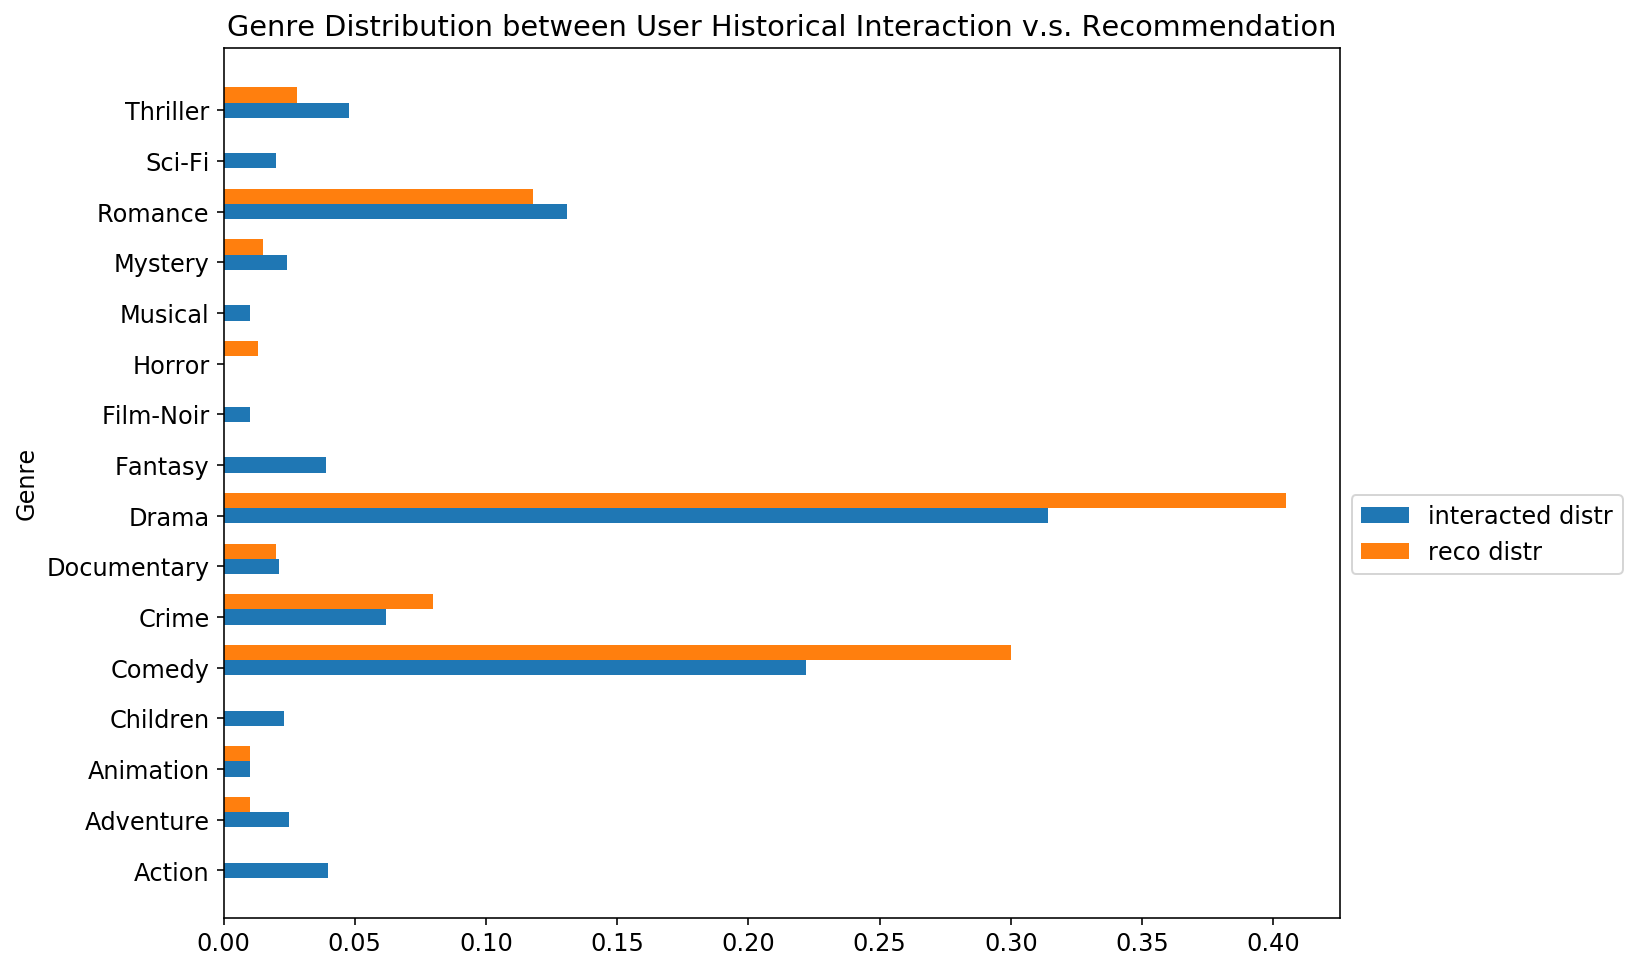

In [46]:
calib_reco_distr = compute_genre_distr(calib_reco_items)
distr_comparison_plot(interacted_distr, calib_reco_distr)

In [ ]:
reco_items

In [47]:
topn = 50
user_id = 100
lmbda = 0.9

prec_cal = 0
kl_cal = 0
kl_rec = 0
prec_rec = 0
n = 0

for user_id in tqdm(range(1, 11)):
    try:
        reco = bpr.recommend(user_id, user_item_train, N=topn)
        reco_items = [item_mapping[index2item[index]] for index, _ in reco]
        reco_distr = compute_genre_distr(reco_items)

        interacted_ids = user_item_train[user_id].nonzero()[1]
        interacted_items = [item_mapping[index2item[index]] for index in interacted_ids]
        interacted_distr = compute_genre_distr(interacted_items)

        items = generate_item_candidates(bpr, user_item_train, user_id, index2item, item_mapping)
        calib_reco_items = calib_recommend(items, interacted_distr, topn, lmbda)
        calib_reco_distr = compute_genre_distr(calib_reco_items)

        calib_reco_kl_div = compute_kl_divergence(interacted_distr, calib_reco_distr)
        calib_reco_precision = precision(user_item_test, user_id, calib_reco_items, index2item)
        #print('calibrated reco kl-divergence score:', calib_reco_kl_div)
        #print('calibrated reco precision score:', calib_reco_precision)
        #distr_comparison_plot(interacted_distr, calib_reco_distr)

        reco_kl_div = compute_kl_divergence(interacted_distr, reco_distr)
        reco_precision = precision(user_item_test, user_id, reco_items, index2item)
        #print('original reco kl-divergence score:', reco_kl_div)
        #print('original reco precision score:', reco_precision)
        #distr_comparison_plot(interacted_distr, reco_distr)

        prec_rec += reco_precision
        prec_cal += calib_reco_precision
        kl_rec += reco_kl_div
        kl_cal += calib_reco_kl_div
        n += 1
    except:
        continue

print('calibrated reco kl-divergence score:', kl_cal/n)
print('calibrated reco precision score:', prec_cal/n)
print('original reco kl-divergence score:', kl_rec/n)
print('original reco precision score:', prec_rec/n)


calibrated reco kl-divergence score: 0.18556420531459877
calibrated reco precision score: 0.36538720538720537
original reco kl-divergence score: 0.5532788957870228
original reco precision score: 0.3098316498316498
